# Mortgage Scenario Analysis

Run all cells to see the analysis.

In [77]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Set display options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.style.use('seaborn-v0_8-whitegrid' if 'seaborn-v0_8-whitegrid' in plt.style.available else 'bmh')


In [78]:

# ==========================================
#               INPUTS
# ==========================================

# --- Current Loan Details ---
CURRENT_BALANCE = 1e6
CURRENT_RATE = 6.0           # Annual Interest Rate (%)
REMAINING_TERM_MONTHS = 29*12  # e.g., 25 years * 12

# --- Lump Sum Scenario ---
LUMP_SUM_AMOUNT = 100000.00
LUMP_SUM_MONTH = 1           # Month index to apply payment (1 = next month)

# --- Refinance Scenario Options ---
REFI_RATE = 5.0              # New Refinance Rate (%)
REFI_TERM_YEARS = 30         # New Term
REFI_COST = 4000.00          # Closing costs added to loan or paid upfront

# --- Investment Comparison ---
INVESTMENT_RETURN = 5.0      # Expected annual return if you invested the lump sum instead (%)

print("Inputs Loaded.")


Inputs Loaded.


In [79]:

def calculate_amortization(balance, rate, term_months, lump_sum=0, lump_sum_month=None, recast=False, monthly_payment_override=None):
    
    monthly_rate = rate / 100 / 12
    
    # Calculate initial monthly payment if not provided
    if monthly_payment_override:
        payment = monthly_payment_override
    else:
        if monthly_rate == 0:
            payment = balance / term_months
        else:
            payment = (balance * monthly_rate) / (1 - (1 + monthly_rate) ** (-term_months))
            
    schedule = []
    remaining_balance = balance
    cumulative_interest = 0
    cumulative_paid = 0
    
    # For Recast logic
    current_payment = payment
    
    # Iterate through months. Max iteration 60 years to be safe
    for month in range(1, 721):
        if remaining_balance <= 1e-2:
            break

        # Handle Lump Sum
        extra_principal = 0
        if lump_sum_month == month:
            extra_principal = lump_sum
            
        # Interest for this month
        interest_payment = remaining_balance * monthly_rate
        
        # Recast Logic: re-calc payment after lump sum
        if recast and month == lump_sum_month + 1:
            months_left = max(1, term_months - (month - 1))
            if monthly_rate == 0:
                current_payment = remaining_balance / months_left
            else:
                current_payment = (remaining_balance * monthly_rate) / (1 - (1 + monthly_rate) ** (-months_left))

        total_due = interest_payment + remaining_balance
        regular_payment_part = min(current_payment, total_due)
        principal_payment = regular_payment_part - interest_payment
        
        # Total cash out this month
        total_cash_out = regular_payment_part + extra_principal
        
        # Update balance
        remaining_balance -= (principal_payment + extra_principal)
        
        cumulative_interest += interest_payment
        cumulative_paid += total_cash_out
        
        schedule.append({
            'Month': month,
            'Payment': total_cash_out,
            'Principal': principal_payment + extra_principal,
            'Interest': interest_payment,
            'Balance': max(0, remaining_balance),
            'Cumulative_Interest': cumulative_interest,
            'Cumulative_Paid': cumulative_paid
        })
        
    return pd.DataFrame(schedule)

print("Calculator Function Defined.")


Calculator Function Defined.


In [80]:

# --- Run Scenarios ---

# 1. Baseline
df_base = calculate_amortization(
    CURRENT_BALANCE, 
    CURRENT_RATE, 
    REMAINING_TERM_MONTHS
)
df_base['Scenario'] = 'Baseline'

# 2. Lump Sum (No Recast)
df_no_recast = calculate_amortization(
    CURRENT_BALANCE, 
    CURRENT_RATE, 
    REMAINING_TERM_MONTHS,
    lump_sum=LUMP_SUM_AMOUNT,
    lump_sum_month=LUMP_SUM_MONTH,
    recast=False
)
df_no_recast['Scenario'] = 'Lump Sum (No Recast)'

# 3. Lump Sum (Recast)
df_recast = calculate_amortization(
    CURRENT_BALANCE, 
    CURRENT_RATE, 
    REMAINING_TERM_MONTHS,
    lump_sum=LUMP_SUM_AMOUNT,
    lump_sum_month=LUMP_SUM_MONTH,
    recast=True
)
df_recast['Scenario'] = 'Lump Sum (Recast)'

# 4. Refinance
df_refi = calculate_amortization(
    CURRENT_BALANCE + REFI_COST, 
    REFI_RATE, 
    REFI_TERM_YEARS * 12
)
df_refi['Scenario'] = 'Refinance'

# 5. Invest Strategy (Comparison)
df_invest = df_base.copy()
df_invest['Scenario'] = 'Invest Lump Sum'
monthly_return = INVESTMENT_RETURN / 100 / 12
inv_balance = []
curr_inv = 0

for m in df_invest['Month']:
    if m == LUMP_SUM_MONTH:
        curr_inv += LUMP_SUM_AMOUNT
    curr_inv *= (1 + monthly_return)
    inv_balance.append(curr_inv)

df_invest['Investment_Balance'] = inv_balance

print("Scenarios Calculated.")


Scenarios Calculated.


In [81]:

# ==========================================
#               ANALYSIS
# ==========================================

def get_summary(df, scenario_name, initial_cash_out=0):
    last_row = df.iloc[-1]
    
    # Monthly payment (taking the mode or mean of standard payments)
    # Filter out outliers (like the lump sum itself)
    regular_payments = df[df['Payment'] < (df['Payment'].median() * 2)]['Payment']
    
    # Get the most common payment value (mode) to avoid averaging small floating point diffs
    avg_payment = regular_payments.mode()[0] if not regular_payments.empty else df['Payment'].mean()
    
    if scenario_name == '3. Lump Sum (Recast)':
        # For recast, we want the NEW payment AFTER the lump sum month
        # We look for payments after the lump sum month
        post_recast_payments = df[df['Month'] > LUMP_SUM_MONTH]['Payment']
        if not post_recast_payments.empty:
            avg_payment = post_recast_payments.iloc[0]
        
    total_interest = last_row['Cumulative_Interest']
    total_paid = last_row['Cumulative_Paid'] + initial_cash_out
    months = last_row['Month']
    
    net_cost = total_paid
    investment_value = 0
    if 'Investment_Balance' in df.columns:
        investment_value = df.iloc[-1]['Investment_Balance']
        net_cost = total_paid - investment_value
    
    return {
        "Scenario": scenario_name,
        "Monthly Payment": avg_payment,
        "Total Interest Paid": total_interest,
        "Total Cash Outflow": total_paid,
        "Investment Value": investment_value,
        "Net Cost (Paid - Invest)": net_cost,
        "Payoff Month": int(months),
        "Years to Payoff": months / 12
    }

# Ensure names match strictly for indexing later
summaries = [
    get_summary(df_base, "1. Baseline"),
    get_summary(df_no_recast, "2. Lump Sum (No Recast)"),
    get_summary(df_recast, "3. Lump Sum (Recast)"),
    get_summary(df_refi, "4. Refinance", initial_cash_out=0),
    get_summary(df_invest, "5. Invest Strategy")
]

summary_df = pd.DataFrame(summaries).set_index("Scenario")

display_cols = ["Monthly Payment", "Total Interest Paid", "Total Cash Outflow", "Investment Value", "Net Cost (Paid - Invest)", "Years to Payoff"]
print("\n--- SUMMARY TABLE ---")
display(summary_df[display_cols].style.format("${:,.2f}", subset=display_cols[:-1]).format("{:.1f}", subset=["Years to Payoff"]))

# --- Monthly Payment Difference Table ---
print("\n--- MONTHLY PAYMENT IMPACT (Cashflow) ---")
payment_df = summary_df[['Monthly Payment']].copy()

# Robustly get baseline payment
try:
    base_payment = payment_df.loc['1. Baseline', 'Monthly Payment']
except KeyError:
    # Fallback if index name is slightly different
    base_payment = payment_df.iloc[0]['Monthly Payment']

# Calculate Savings (Baseline - New Payment)
# Positive number = Savings (Money kept in pocket)
# Negative number = Cost Increase
payment_df['Monthly Savings'] = base_payment - payment_df['Monthly Payment']
payment_df['Annual Savings'] = payment_df['Monthly Savings'] * 12
payment_df['5-Year Savings'] = payment_df['Annual Savings'] * 5

# Style: Green for savings, Red for negative (if any)
def color_savings(val):
    color = 'green' if val > 0.01 else 'red' if val < -0.01 else 'black'
    return 'color: %s' % color

display(payment_df.style.format("${:,.2f}").applymap(color_savings, subset=['Monthly Savings', 'Annual Savings', '5-Year Savings']))



--- SUMMARY TABLE ---


,Monthly Payment,Total Interest Paid,Total Cash Outflow,Investment Value,Net Cost (Paid - Invest),Years to Payoff
Scenario,,,,,,
1. Baseline,"$6,070.05","$1,112,376.05","$2,112,376.05",$0.00,"$2,112,376.05",29.0
2. Lump Sum (No Recast),"$6,070.05","$747,691.85","$1,747,691.85",$0.00,"$1,747,691.85",22.7
3. Lump Sum (Recast),"$5,462.39","$1,001,519.83","$2,001,519.83",$0.00,"$2,001,519.83",29.0
4. Refinance,"$5,389.69","$936,288.07","$1,940,288.07",$0.00,"$1,940,288.07",30.0
5. Invest Strategy,"$6,070.05","$1,112,376.05","$2,112,376.05","$425,029.13","$1,687,346.92",29.0



--- MONTHLY PAYMENT IMPACT (Cashflow) ---


/var/folders/0p/3mbt9gm91jn236g6qf0mkz380000gn/T/ipykernel_71682/2399607614.py:81: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(payment_df.style.format("${:,.2f}").applymap(color_savings, subset=['Monthly Savings', 'Annual Savings', '5-Year Savings']))


,Monthly Payment,Monthly Savings,Annual Savings,5-Year Savings
Scenario,,,,
1. Baseline,"$6,070.05",$0.00,$0.00,$0.00
2. Lump Sum (No Recast),"$6,070.05",$0.00,$0.00,$0.00
3. Lump Sum (Recast),"$5,462.39",$607.65,"$7,291.86","$36,459.29"
4. Refinance,"$5,389.69",$680.36,"$8,164.28","$40,821.42"
5. Invest Strategy,"$6,070.05",$0.00,$0.00,$0.00


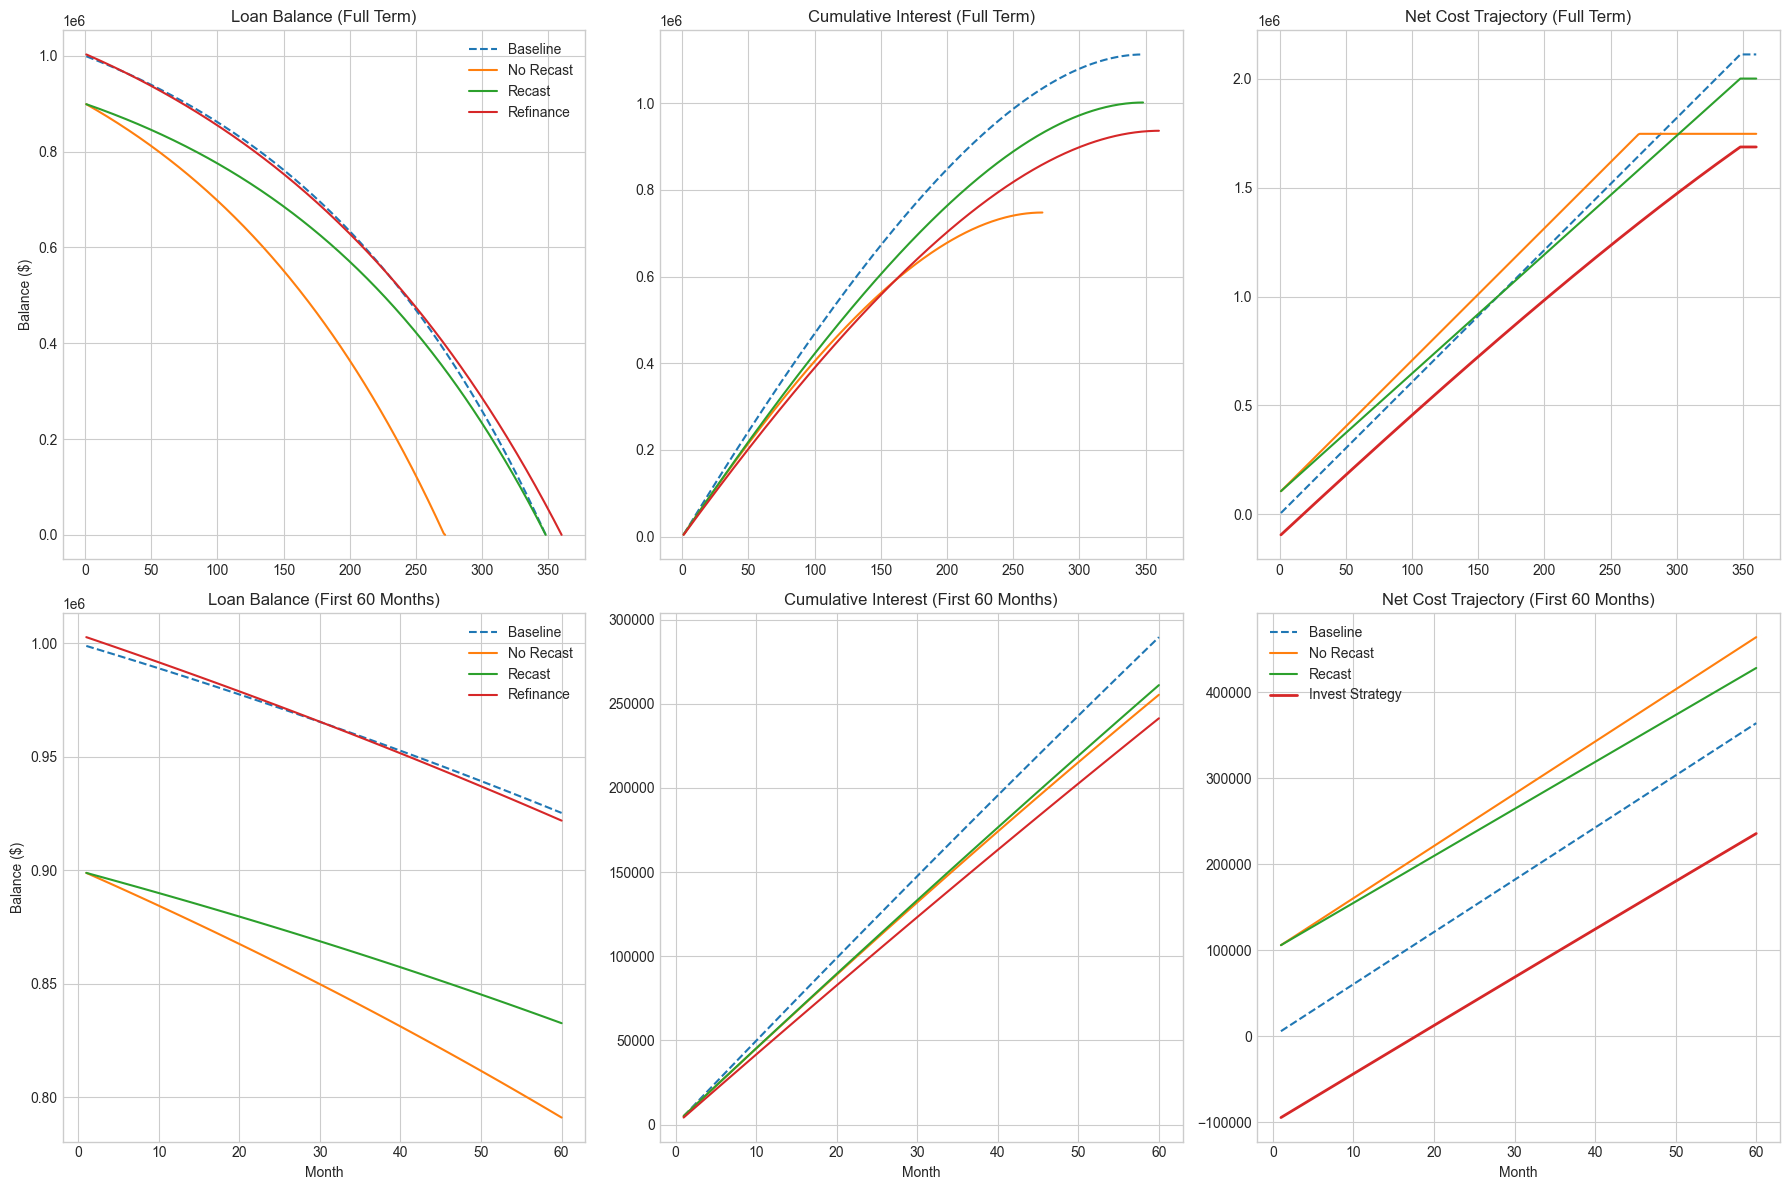

In [82]:

# ==========================================
#               PLOTS
# ==========================================

# Create 2 rows x 3 columns grid
# Row 1: Full Term
# Row 2: First 5 Years (Zoomed)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# --- ROW 1: FULL TERM ---

# 1.1 Loan Balance
ax = axes[0, 0]
ax.plot(df_base['Month'], df_base['Balance'], label='Baseline', linestyle='--')
ax.plot(df_no_recast['Month'], df_no_recast['Balance'], label='No Recast')
ax.plot(df_recast['Month'], df_recast['Balance'], label='Recast')
ax.plot(df_refi['Month'], df_refi['Balance'], label='Refinance')
ax.set_title('Loan Balance (Full Term)')
ax.set_ylabel('Balance ($)')
ax.legend()

# 1.2 Cumulative Interest
ax = axes[0, 1]
ax.plot(df_base['Month'], df_base['Cumulative_Interest'], label='Baseline', linestyle='--')
ax.plot(df_no_recast['Month'], df_no_recast['Cumulative_Interest'], label='No Recast')
ax.plot(df_recast['Month'], df_recast['Cumulative_Interest'], label='Recast')
ax.plot(df_refi['Month'], df_refi['Cumulative_Interest'], label='Refinance')
ax.set_title('Cumulative Interest (Full Term)')

# 1.3 Net Cost
max_month = max(df_base['Month'].max(), df_refi['Month'].max())
common_idx = range(1, int(max_month) + 1)

def get_net_trajectory(df, is_invest=False):
    # Reindex to common timeline
    temp = df.set_index('Month').reindex(common_idx)
    # Forward fill cumulative values
    temp['Cumulative_Paid'] = temp['Cumulative_Paid'].ffill()
    if is_invest:
        temp['Investment_Balance'] = temp['Investment_Balance'].ffill()
        return temp['Cumulative_Paid'] - temp['Investment_Balance']
    return temp['Cumulative_Paid']

ax = axes[0, 2]
ax.plot(common_idx, get_net_trajectory(df_base), label='Baseline', linestyle='--')
ax.plot(common_idx, get_net_trajectory(df_no_recast), label='No Recast')
ax.plot(common_idx, get_net_trajectory(df_recast), label='Recast')
ax.plot(common_idx, get_net_trajectory(df_invest, is_invest=True), label='Invest Strategy', linewidth=2)
ax.set_title('Net Cost Trajectory (Full Term)')


# --- ROW 2: ZOOMED (First 60 Months) ---
ZOOM = 60

# 2.1 Loan Balance
ax = axes[1, 0]
ax.plot(df_base[df_base['Month']<=ZOOM]['Month'], df_base[df_base['Month']<=ZOOM]['Balance'], label='Baseline', linestyle='--')
ax.plot(df_no_recast[df_no_recast['Month']<=ZOOM]['Month'], df_no_recast[df_no_recast['Month']<=ZOOM]['Balance'], label='No Recast')
ax.plot(df_recast[df_recast['Month']<=ZOOM]['Month'], df_recast[df_recast['Month']<=ZOOM]['Balance'], label='Recast')
ax.plot(df_refi[df_refi['Month']<=ZOOM]['Month'], df_refi[df_refi['Month']<=ZOOM]['Balance'], label='Refinance')
ax.set_title(f'Loan Balance (First {ZOOM} Months)')
ax.set_ylabel('Balance ($)')
ax.set_xlabel('Month')
ax.legend()

# 2.2 Cumulative Interest
ax = axes[1, 1]
ax.plot(df_base[df_base['Month']<=ZOOM]['Month'], df_base[df_base['Month']<=ZOOM]['Cumulative_Interest'], label='Baseline', linestyle='--')
ax.plot(df_no_recast[df_no_recast['Month']<=ZOOM]['Month'], df_no_recast[df_no_recast['Month']<=ZOOM]['Cumulative_Interest'], label='No Recast')
ax.plot(df_recast[df_recast['Month']<=ZOOM]['Month'], df_recast[df_recast['Month']<=ZOOM]['Cumulative_Interest'], label='Recast')
ax.plot(df_refi[df_refi['Month']<=ZOOM]['Month'], df_refi[df_refi['Month']<=ZOOM]['Cumulative_Interest'], label='Refinance')
ax.set_title(f'Cumulative Interest (First {ZOOM} Months)')
ax.set_xlabel('Month')

# 2.3 Net Cost
# For net cost, we slice the Series we generated earlier
common_idx_zoom = range(1, ZOOM + 1)
net_base = get_net_trajectory(df_base)
net_no_recast = get_net_trajectory(df_no_recast)
net_recast = get_net_trajectory(df_recast)
net_invest = get_net_trajectory(df_invest, is_invest=True)

# Helper to slice safely
def safe_slice(series, limit):
    return series.loc[series.index <= limit]

ax = axes[1, 2]
# Using .loc for alignment
ax.plot(common_idx_zoom, safe_slice(net_base, ZOOM), label='Baseline', linestyle='--')
ax.plot(common_idx_zoom, safe_slice(net_no_recast, ZOOM), label='No Recast')
ax.plot(common_idx_zoom, safe_slice(net_recast, ZOOM), label='Recast')
ax.plot(common_idx_zoom, safe_slice(net_invest, ZOOM), label='Invest Strategy', linewidth=2)
ax.set_title(f'Net Cost Trajectory (First {ZOOM} Months)')
ax.set_xlabel('Month')
ax.legend()

plt.tight_layout()
plt.show()
